# Results

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

# sns.reset_orig()
%load_ext autoreload
%autoreload 2

# rc("text", usetex=True)
# plt.grid(b=None)
# # plt.style.use('fivethirtyeight')
# sns.set(style="whitegrid")

## Beijing A

In [2]:
splits = 6

In [3]:
temp = []
for reg in ['las', 'knn', 'xgb', 'xgbRF', 'svr', 'gpST']:
    try:
        odf = pd.read_csv(f"../exp1/src/results/beijinga_scaled/{reg}/final.csv")        
        new_temp = odf[odf["is_val_error"] == False]
        lastKDayss = new_temp['lastKDays'].unique()
        for lastKDays in lastKDayss:
            temp.append(new_temp[(new_temp['lastKDays'] == lastKDays) & (new_temp['time_ix'] >= lastKDays - 1)])
    except FileNotFoundError:
        pass
df = pd.concat(temp)
# df = df.append(interpols)
df = df[~(df['reg'] == "SVGP") & ~(df['lastKDays'].isin([100, 200]))]
# plt.figure(figsize=(12, 8))
df = df.rename(columns={"reg": "Method"})


In [4]:
df.head()

,is_val_error,Method,stepSize,lastKDays,kout,kin,time_ix,hy_ix,rmse,mae
6568,False,Lasso,2,10,0,-1,29,7,45.028495,43.616394
6569,False,Lasso,2,10,0,-1,31,7,25.015194,24.804973
6570,False,Lasso,2,10,0,-1,33,7,10.556225,8.817482
6571,False,Lasso,2,10,0,-1,35,7,14.143677,12.072854
6572,False,Lasso,2,10,0,-1,37,7,26.068308,23.852236


In [5]:
temp = {
    "Method": [],
    "time_ix": [],
    "rmse": [],
    "mae": [],
    "kout": [],
}
for called_reg, reg in zip(['IDW', 'Kriging', 'Spatial GP'], ['idw', 'krig', 'spatial_gp']):
    df_rmse = pd.read_csv(f"../exp1/interpol_baselines/{reg}_rmse.csv").T
    df_mae = pd.read_csv(f"../exp1/interpol_baselines/{reg}_mae.csv").T
    for ix, row in enumerate(sorted(df_rmse.index)):
        if ix % 2 == 0:
            continue
        temp["Method"].extend([called_reg] * splits)
        temp["time_ix"].extend([ix] * splits)
        temp["rmse"].extend(list(df_rmse.loc[row][[i for i in range(splits)]]))
        temp["mae"].extend(list(df_mae.loc[row][[i for i in range(splits)]]))
        temp["kout"].extend(list(range(splits)))

values_total = len(temp["Method"])
temp["lastKDays"] = [1] * values_total
temp["is_val_error"] = [False] * values_total
temp["stepSize"] = [2] * values_total
temp["kin"] = [-1] * values_total
temp["kout"] = [-1] * values_total
temp["hy_ix"] = [-1] * values_total
for col in df.columns:
    temp[col]
interpols = pd.DataFrame(temp)[df.columns]
interpols.head()

,is_val_error,Method,stepSize,lastKDays,kout,kin,time_ix,hy_ix,rmse,mae
0,False,IDW,2,1,-1,-1,1,-1,7.880223,7.321755
1,False,IDW,2,1,-1,-1,1,-1,11.665378,7.219419
2,False,IDW,2,1,-1,-1,1,-1,10.522260,9.401343
3,False,IDW,2,1,-1,-1,1,-1,8.760199,6.997543
4,False,IDW,2,1,-1,-1,1,-1,8.268696,6.032451


In [6]:
df = df.append(interpols)

In [7]:
df.tail()

,is_val_error,Method,stepSize,lastKDays,kout,kin,time_ix,hy_ix,rmse,mae
3217,False,Spatial GP,2,1,-1,-1,357,-1,10.940519,7.763604
3218,False,Spatial GP,2,1,-1,-1,357,-1,16.353066,12.934362
3219,False,Spatial GP,2,1,-1,-1,357,-1,10.642272,9.431575
3220,False,Spatial GP,2,1,-1,-1,357,-1,16.441371,13.127388
3221,False,Spatial GP,2,1,-1,-1,357,-1,13.671508,12.020739


Text(0.5, 1.0, 'Average Test Performances Using Nested Cross Validation on Beijing A.')

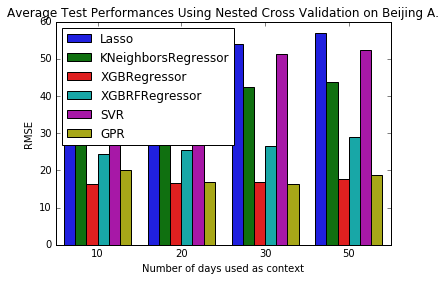

In [8]:
df = df[~(df['lastKDays'] == 1)]
sns.barplot(data=df, x="lastKDays", y="rmse", hue="Method", errwidth=0)
plt.ylabel("RMSE")
plt.xlabel("Number of days used as context")
plt.legend(loc="upper left")
plt.title(f"Average Test Performances Using Nested Cross Validation on Beijing A.")

In [9]:
from common_functions import latexify, format_axes, tableau20blind
latexify(12, 8)
# latexify(columns=1)

In [10]:
def create_good_df(df):
    emptydf = pd.DataFrame(columns=list(df["Method"].unique()) + ["lastKDays"])
    emptydf

    for l, tempdf in df.groupby("lastKDays"):
        d = {}
        for method, tempdf1 in tempdf.groupby("Method"):
            d[method] = tempdf1["rmse"].mean()
    #     break
        temp = [d.get(col, np.nan) for col in emptydf.columns[:-1]]
        emptydf.loc[emptydf.shape[0]] = temp + [int(l)]

    emptydf['lastKDays'] = emptydf['lastKDays'].astype(int)
    emptydf = emptydf.set_index("lastKDays")
    emptydf = emptydf.rename(columns={"XGBRegressor": "XGB", "KNeighborsRegressor": "KNN"})
    try:
        emptydf.drop(columns=["XGBRFRegressor"], inplace=True)
    except KeyError:
        pass
    emptydf = emptydf[['GPR', 'XGB', 'KNN', 'SVR', 'Lasso']]
    return emptydf

In [11]:
params = {
    'lines.linewidth': 2,
    'lines.color': 'k',
#     'boxplot.boxprops.linewidth': 20,
    'boxplot.boxprops.color': 'k',
    'patch.linewidth': 3,
    'legend.fontsize': 14 + 4,
    'legend.framealpha': .6,
    'axes.titlesize': 14 + 4,
    "axes.labelsize": 14 + 4,
    'xtick.labelsize': 14 + 4,
    'ytick.labelsize': 16 + 4,
    'axes.labelweight': 'bold',
    'axes.linewidth': 10,
    'font.weight': 'bold'
    
}
matplotlib.rcParams.update(params)

In [12]:
emptydf = create_good_df(df)
emptydf

,GPR,XGB,KNN,SVR,Lasso
lastKDays,,,,,
10,20.234332,16.451227,41.430106,52.093573,46.514080
20,16.796107,16.510089,41.703029,47.626328,50.932437
30,16.288170,16.867541,42.475588,51.156615,53.955834
50,18.677015,17.813530,43.710305,52.445328,56.925773


/home/apoorv/Desktop/github/.env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


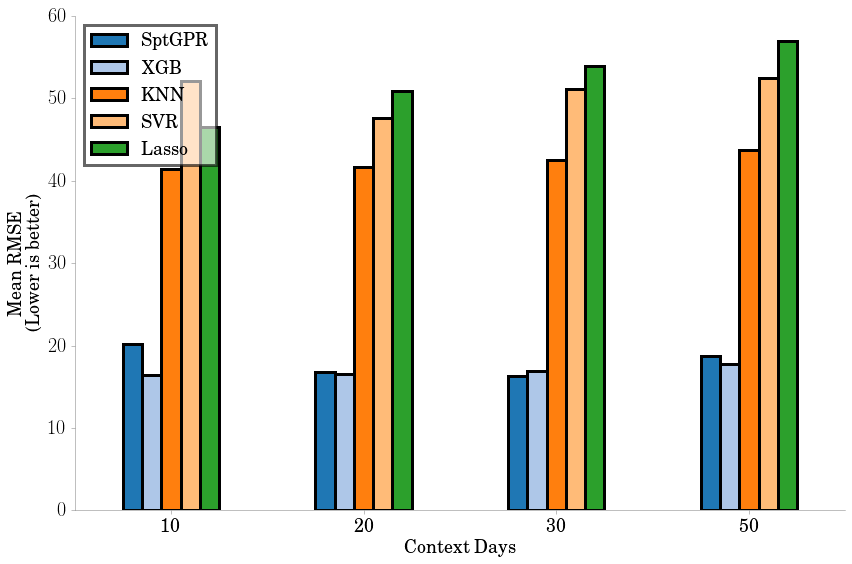

In [13]:
# plt.figure(figsize=(12, 8))
emptydf = emptydf.rename(columns={"GPR": "SptGPR"})
emptydf.plot(kind="bar",rot=0, colors=tableau20blind)
format_axes(plt.gca())
plt.ylabel("Mean RMSE\n(Lower is better)")
plt.xlabel("Context Days")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("exp1a.pdf")
plt.show()

In [14]:
df.groupby(["lastKDays", "Method"]).mean()

is_val_error  stepSize      kout  kin  \
lastKDays Method                                                       
10        GPR                         False       2.0  2.522655 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRFRegressor              False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
20        GPR                         False       2.0  2.494565 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRFRegressor              False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
30        GPR                         False       2.0  2.515385 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRFRegressor              False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
50        GPR                         False       2.0  2.549941 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRFRegressor              False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   

                                  time_ix  hy_ix       rmse        mae  
lastKDays Method                                                        
10        GPR                  194.850369   -1.0  20.234332  16.865000  
          KNeighborsRegressor  183.000000    9.0  41.430106  37.572285  
          Lasso                183.000000    7.0  46.514080  43.088327  
          SVR                  183.000000    5.0  52.093573  48.268716  
          XGBRFRegressor       193.000000   12.0  24.308331  20.369007  
          XGBRegressor         183.000000   12.0  16.451227  12.708142  
20        GPR                  193.873913   -1.0  16.796107  13.413240  
          KNeighborsRegressor  188.000000    9.0  41.703029  37.786218  
          Lasso                188.000000    7.0  50.932437  47.415423  
          SVR                  188.000000    5.0  47.626328  43.678932  
          XGBRFRegressor       193.000000   12.0  25.434430  21.488283  
          XGBRegressor         188.000000   12.0  16.510089  12.771814  
30        GPR                  192.419780   -1.0  16.288170  12.894913  
          KNeighborsRegressor  193.000000    9.0  42.475588  38.503464  
          Lasso                193.000000    7.0  53.955834  50.392806  
          SVR                  193.000000    5.0  51.156615  47.148515  
          XGBRFRegressor       193.000000   12.0  26.565905  22.508101  
          XGBRegressor         193.000000   12.0  16.867541  13.152681  
50        GPR                  203.277321   -1.0  18.677015  15.079429  
          KNeighborsRegressor  203.000000    9.0  43.710305  39.622827  
          Lasso                203.000000    7.0  56.925773  53.146212  
          SVR                  203.000000    5.0  52.445328  48.303722  
          XGBRFRegressor       203.000000   12.0  28.908094  24.867795  
          XGBRegressor         203.000000   12.0  17.813530  14.030682

## Beijing B

In [15]:
temp = []
for reg in ['las', 'knn', 'xgb', 'xgbRF', 'svr', "gpFULL"]:
    try:
        odf = pd.read_csv(f"../exp1/src/results/beijingb_scaled/{reg}/final.csv")
        new_temp = odf[odf["is_val_error"] == False]
        lastKDayss = new_temp['lastKDays'].unique()
        for lastKDays in lastKDayss:
            temp.append(new_temp[(new_temp['lastKDays'] == lastKDays) & (new_temp['time_ix'] >= lastKDays - 1)])
    except FileNotFoundError:
        pass
df = pd.concat(temp)
# df = df.append(interpols)
df = df[~(df['reg'] == "SVGP") & ~(df['lastKDays'].isin([100, 200]))]
df = df.rename(columns={"reg": "Method"})
emptydf = create_good_df(df)
emptydf

# plt.figure(figsize=(12, 8))
# sns.barplot(data=df, x = "lastKDays", y="rmse", hue="Method", errwidth=0)
# plt.ylabel("RMSE")
# plt.xlabel("Number of days used as context")
# plt.title(f"Average Test Performances Using Nested Cross Validation on Beijing B.")

,GPR,XGB,KNN,SVR,Lasso
lastKDays,,,,,
10,16.691106,17.239761,21.008332,22.005239,28.128604
20,16.253796,17.543402,23.356580,26.036364,34.100062
30,15.568837,17.205029,23.485494,27.494888,35.216964
50,16.619074,18.228240,24.204462,29.965899,37.542553


<Figure size 864x576 with 0 Axes>

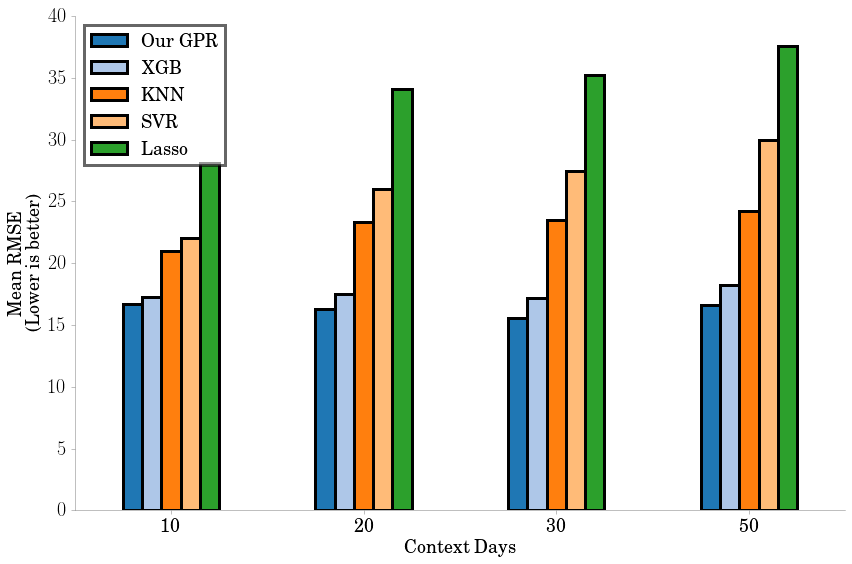

In [16]:
plt.figure(figsize=(12, 8))
emptydf = emptydf.rename(columns={"GPR": "Our GPR"})
emptydf.plot(kind="bar",rot=0)#, colors=tableau20blind)
format_axes(plt.gca())
plt.ylabel("Mean RMSE\n(Lower is better)")
plt.xlabel("Context Days")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("exp1b.pdf")
# plt.savefig("exp1b.pdf")
plt.show()

In [17]:
df.groupby(["lastKDays", "Method"]).mean()

is_val_error  stepSize      kout  kin  \
lastKDays Method                                                       
10        GPR                         False       2.0  2.518947 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
20        GPR                         False       2.0  2.520879 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
30        GPR                         False       2.0  2.514739 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   
50        GPR                         False       2.0  2.538835 -1.0   
          KNeighborsRegressor         False       2.0  2.500000 -1.0   
          Lasso                       False       2.0  2.500000 -1.0   
          SVR                         False       2.0  2.500000 -1.0   
          XGBRegressor                False       2.0  2.500000 -1.0   

                                  time_ix  hy_ix       rmse        mae  
lastKDays Method                                                        
10        GPR                  194.345263   -1.0  16.691106  13.144337  
          KNeighborsRegressor  193.000000    9.0  21.008332  16.236408  
          Lasso                193.000000    7.0  28.128604  23.345789  
          SVR                  193.000000    5.0  22.005239  17.376902  
          XGBRegressor         193.000000   12.0  17.239761  13.284435  
20        GPR                  191.942857   -1.0  16.253796  12.679077  
          KNeighborsRegressor  193.000000    9.0  23.356580  18.296314  
          Lasso                193.000000    7.0  34.100062  29.533959  
          SVR                  193.000000    5.0  26.036364  21.227913  
          XGBRegressor         193.000000   12.0  17.543402  13.583216  
30        GPR                  190.324263   -1.0  15.568837  12.313509  
          KNeighborsRegressor  193.000000    9.0  23.485494  18.427939  
          Lasso                193.000000    7.0  35.216964  30.421231  
          SVR                  193.000000    5.0  27.494888  22.500702  
          XGBRegressor         193.000000   12.0  17.205029  13.341834  
50        GPR                  200.388350   -1.0  16.619074  13.216775  
          KNeighborsRegressor  203.000000    9.0  24.204462  19.017451  
          Lasso                203.000000    7.0  37.542553  32.488278  
          SVR                  203.000000    5.0  29.965899  24.699893  
          XGBRegressor         203.000000   12.0  18.228240  14.256060